In [10]:
import numpy as np
import torch 
import matplotlib.pyplot as plt

import sigkernel as ksig_pde
import sigkernel_ as ksig_disc
import utils.data
from generators.generators import *
from generators.ESN import ESNGenerator
from models.ESN_MMD_mvp_trainer import train_ESN_MMD_mvp 
from sigkernel_.loss import compute_mmd_loss

%load_ext autoreload
%autoreload 2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype=torch.float64

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Kernel calls

## Sequential

- **Note:** The following kernels require inputs of shape `torch.Size([N, T, d])`, where:
    - **N**: number of samples (N i.i.d. paths)
    - **T**: length of each path
    - **d**: dimension of the data  
      - Use **d = 1** for just the time series values  
      - Use **d = 2** if timestep information is added, i.e., each path is \( X_t = (t, X(t)) \)

In [11]:
# Get discretized signature kernel
static_kernel_type = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels           = 10 # number of levels in the truncated signature kernel
disc_sig_kernel_sigma       = 1e-5 # bandwidth parameter for the static kernel

kwargs = {
    'static_kernel_type': static_kernel_type,
    'n_levels': n_levels,
    'kernel_sigma': disc_sig_kernel_sigma,
}

# Define the discretized signature kernel
sig_disc_kernel = ksig_disc.kernels.get_discretized_signature_kernel(**kwargs)

In [12]:
# Get pde signature kernel
pde_sig_sigma = 1e1 # bandwidth parameter for the static kernel
static_kernel = ksig_pde.RBFKernel(sigma=pde_sig_sigma) # define static kernel

# Initialize the corresponding signature kernel
sig_pde_kernel = ksig_pde.SigKernel(static_kernel, dyadic_order=0)

## Static

In [13]:
# Get static kernel
static_sigma = 1e3 # bandwidth parameter for the static kernel
rbf_kernel = ksig_disc.kernels.RBFKernel(sigma=static_sigma)

# Decide training parameters

In [14]:
# Generator and ESN details ----------------------
T = 200 # length of time series
N = 20  # number of samples
d = 1   # dimension of time series
p = 2   # AR order
q = 0   # MA order
phi = [0.7, -0.2] # AR coefficients
theta = None # MA coefficients

h, m, d = 500, 20, 1 # ESN hyperparameters: reservoir size, input dimension, output dimension
A = 0.9 * torch.randn(h, h) / (h ** 0.5) # ESN reservoir weight matrix
C = torch.randn(h, m) / (m ** 0.5) # ESN input weight matrix

# Define data generator and esn
x_ar = ARMA(T=T, p=p, q=q, phi=phi, theta=theta)
esn = ESNGenerator(A, C, out_dim=d, xi_scale=1.0, eta_scale=0.05)

target_generator = x_ar

# Kernel details --------------------------------
# choose one:
# kernel = sig_disc_kernel      # discretized signature kernel
kernel = sig_pde_kernel        # pde signature kernel
# kernel = rbf_kernel           # static kernel

if kernel is rbf_kernel:
    kernel_mode = "static"
else:
    kernel_mode = "sequential"

lead_lag = False
lags = 1

# Training details ------------------------------
epochs=200
batch_size=20
lr=1e-3

# Generate sequence
- In practice, one often subsamples from a single long path to obtain independent samples.
- Here, we directly generate multiple independent sequences for simplicity.
- The generator produces paths compatible with the kernels i.e. of shape `torch.Size([N, T, d=1])`. 
- The notation below matches the above: **T** (length of each path), **N** (number of paths), and currently **d=1** (just the time series values).  
    - To include time as a second channel (**d=2**), call:
    
    ```python
    x_ar_time = utils.data.add_time_dimension(x_ar_samples)
    ```

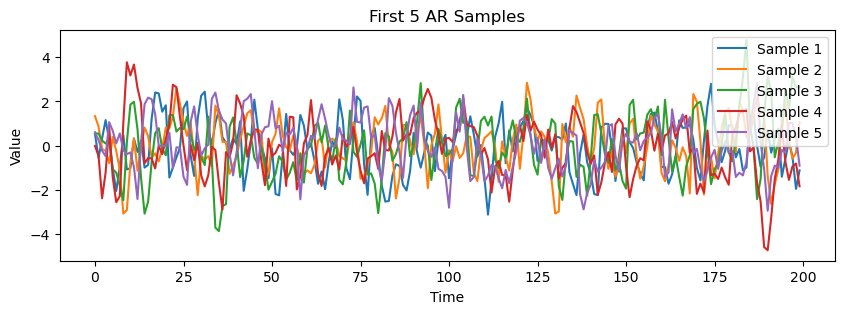

In [15]:
x_ar_samples = x_ar.generate(N=N, noise=Noise("normal"))

plt.figure(figsize=(10, 3))
for idx in range(5):
    plt.plot(x_ar_samples[idx].squeeze().numpy(), label=f'Sample {idx+1}')
plt.title('First 5 AR Samples')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Define ESN
Let $ A \in \mathbb{R}^{N \times N} $, $ C \in \mathbb{R}^{N \times U} $, $ W \in \mathbb{R}^{M \times N} $.  
Let $x_{b,t} \in \mathbb{R}^{N} $, $ \xi_{b,t} \in \mathbb{R}^{U} $, $ \eta_{b,t} \in \mathbb{R}^{M} $, and optionally $ \mathrm{tilt}_{b,t} \in \mathbb{R}^{M} $.  
Let $ \phi(\cdot) $ be the activation function.

State update:
$$
x_{b,t+1} = \phi\!\left( x_{b,t} A^\top + \xi_{b,t} C^\top \right)
$$

Output before tilt:
$$
z_{b,t} = x_{b,t+1} W^\top + \eta_{b,t}
$$

Optional tilt:
$$
z_{b,t} = z_{b,t} + \mathrm{tilt}_{b,t}
$$

Storage:
$$
Z_{b,t} = z_{b,t}, \qquad X_{\text{hist}, b,t} = x_{b,t+1}
$$


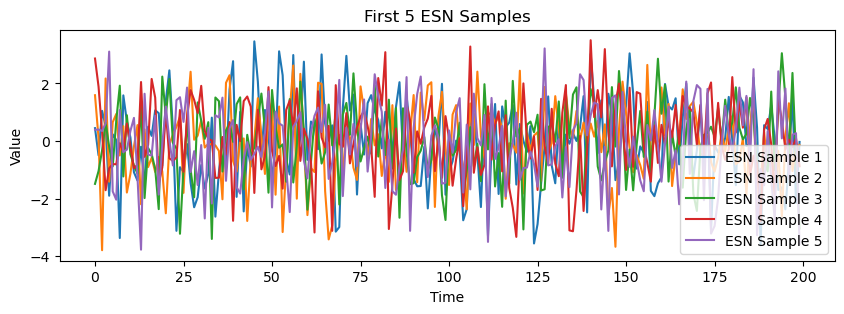

In [16]:
Z_esn = esn(N=N, T=T)
plt.figure(figsize=(10, 3))
for idx in range(5):
    plt.plot(Z_esn.detach().cpu().numpy()[idx].squeeze(), label=f'ESN Sample {idx+1}')
plt.title('First 5 ESN Samples')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

# Check the current MMD

In [17]:
with torch.no_grad():
    X_compare = x_ar.generate(N=N, noise=Noise("normal")).to(device=device, dtype=dtype)
    Z_compare = esn(T=T, N=N).to(device=device, dtype=dtype)

mmd_compare_sig_pde = compute_mmd_loss(sig_pde_kernel, X_compare, Z_compare, lead_lag, lags)
mmd_compare_sig_disc = compute_mmd_loss(sig_disc_kernel, X_compare, Z_compare, lead_lag, lags)
mmd_compare_static = compute_mmd_loss(rbf_kernel, X_compare.reshape(N, -1), Z_compare.reshape(N, -1), lead_lag, lags)
print(f"MMD (PDE Sig Kernel) between AR and ESN samples: {mmd_compare_sig_pde.item():.6f}")
print(f"MMD (Disc Sig Kernel) between AR and ESN samples: {mmd_compare_sig_disc.item():.6f}")
print(f"MMD (Static RBF Kernel) between AR and ESN samples: {mmd_compare_static.item():.6f}")


MMD (PDE Sig Kernel) between AR and ESN samples: 160.531427
MMD (Disc Sig Kernel) between AR and ESN samples: -0.103833
MMD (Static RBF Kernel) between AR and ESN samples: 0.000004


# Train

In [18]:
hist = train_ESN_MMD_mvp(
    esn=esn,
    kernel=kernel,
    kernel_mode=kernel_mode,      # flatten (B,T,d)->(B,T*d) inside the trainer
    T=T,
    epochs=epochs,
    batch_size=batch_size,
    lr=lr,
    lead_lag=lead_lag,
    lags=lags,
    target_generator=target_generator,     # <- oracle target, no dataloader
    device=device,
    dtype=dtype,
)

print("final loss:", hist["losses"][-1])

 50%|█████     | 100/200 [08:23<07:07,  4.27s/it]

Epoch 100/200, Avg last 20: 0.211302


100%|██████████| 200/200 [17:02<00:00,  5.11s/it]

Epoch 200/200, Avg last 20: 0.329991
final loss: 0.45186450582545756


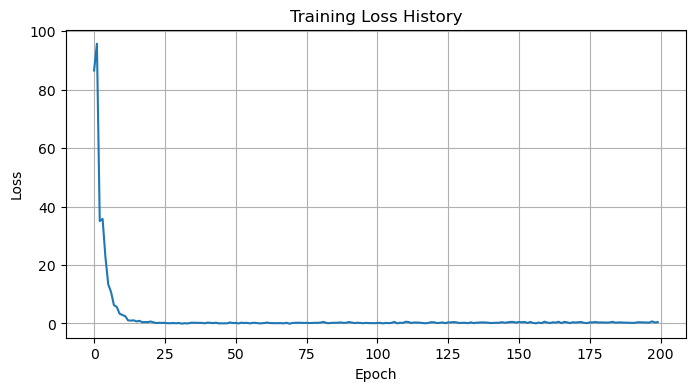

In [19]:
plt.figure(figsize=(8, 4))
plt.plot(hist["losses"])
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# Observe the trained model

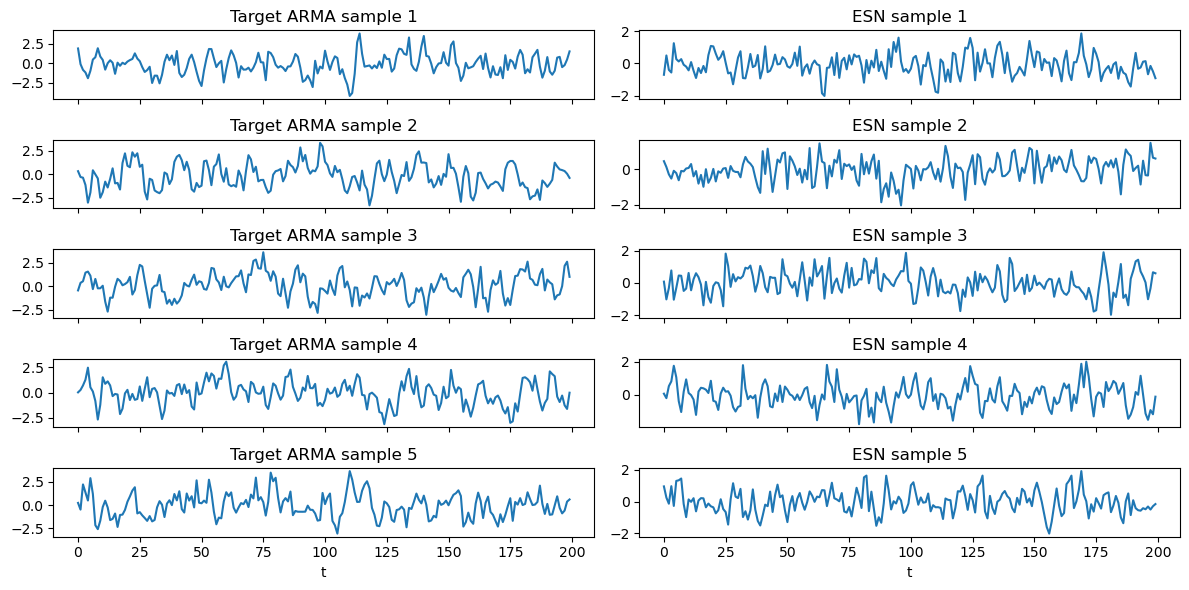

In [25]:
T_plot = T
N_plot = 5

esn.eval()
with torch.no_grad():
    X_tgt = x_ar.generate(N=N_plot, noise=Noise("normal")).cpu()   # (5,T,1)
    Z_esn = esn(T=T_plot, N=N_plot).cpu()                          # (5,T,1)

fig, axes = plt.subplots(nrows=N_plot, ncols=2, figsize=(12, 1.2 * N_plot), sharex=True)
for i in range(N_plot):
    axes[i, 0].plot(X_tgt[i, :, 0].numpy())
    axes[i, 0].set_title(f"Target ARMA sample {i+1}")
    axes[i, 1].plot(Z_esn[i, :, 0].numpy())
    axes[i, 1].set_title(f"ESN sample {i+1}")
for ax in axes[-1, :]:
    ax.set_xlabel("t")
plt.tight_layout()
plt.show()

In [21]:
device = esn.W.device
dtype = esn.A.dtype

with torch.no_grad():
    X = x_ar.generate(N=N, noise=Noise("normal")).to(device=device, dtype=dtype)  
    Z = esn(T=T, N=N).to(device=device, dtype=dtype)                          

if kernel_mode == "static":
    Xk = X.reshape(N, -1)
    Zk = Z.reshape(N, -1)
else:
    Xk, Zk = X, Z

mmd_value = compute_mmd_loss(kernel, Xk, Zk, lead_lag, lags)

print(f"MMD loss (N={N}, T={T}):", float(mmd_value.detach().cpu()))

MMD loss (N=20, T=200): 0.2463490381598228
